# *IT00CH92 Embedded AI - Spring 2024*



# Training MNIST using TensorFlow

## Overview

To effectively deploy deep neural models on resource-constrained edge devices, two critical aspects of model optimization are most useful: pruning, which involves reducing the size of a neural network by eliminating unnecessary parameters, and quantization, which involves reducing the precision of numerical values in the model to conserve memory and computational resources.

For using these techniques, we define the application area by employing the popular LeNet-5 architecture trained on the classic MNIST dataset. LeNet-5, designed by Yann LeCun et al., represents one of the pioneering convolutional neural network (CNN) architectures and remains a benchmark for image classification tasks. At the end of the notebook, we obtain the trained full-precision model to be used for the further steps of the project.

## Setup

In [ ]:
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
tf.random.set_seed(
    seed=81
)

: 

## Using Tensorflow Datasets API to load MNIST

TFDS datasets often come with data already split into different sets. For MNIST, it has splits for train and test. We use the [Slicing API](https://www.tensorflow.org/datasets/splits#slicing_api) for TFDS to create a validation split.

Next, we aim to understand how the dataset is formatted and utilize visualizations. Finally, the dataset is preprocessed before being passed to the model. For preprocessing, we simply normalize the image values as float32 within the range [0, 1] for all three splits.

In [3]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Input image shape: (28, 28, 1)
Image type: <dtype: 'uint8'>
Label shape: ()
Label type: <dtype: 'int64'>


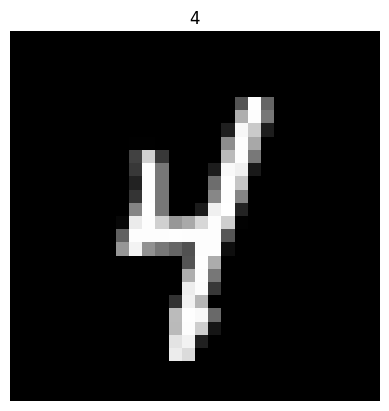

In [19]:
ds = ds_train.take(1)  # Only take a single example
for example in ds:  # example is `('image': tf.Tensor, 'label': tf.Tensor)`
  image = example[0]
  label = example[1]
  print(f"Input image shape: {image.shape}\nImage type: {image.dtype}")
  print(f"Label shape: {label.shape}\nLabel type: {label.dtype}")
  plt.imshow(image, cmap='gray')
  plt.title(label.numpy())
  plt.axis("off")
  plt.show()

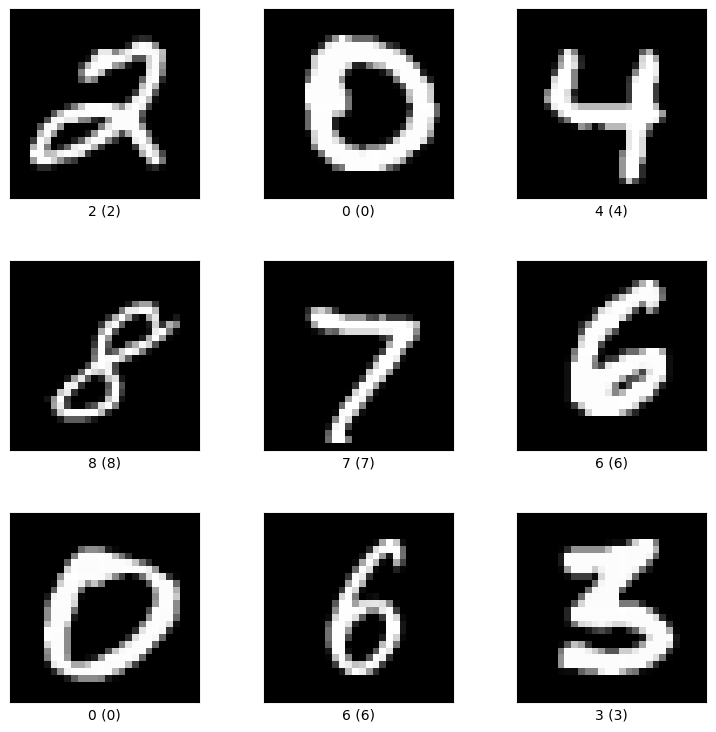

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

### Parameters

In [27]:
batch_size = 128
n_epochs = 4

### Preprocessing

In [28]:
def normalize_img(image:tf.uint8, label:tf.int64):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

def normalize_splits(ds, split_name: str, batch_size: int):
  """Applies preprocessing to train, val and test sets"""
  ds = ds.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE
  )
  ds = ds.cache() # Caching makes it faster for consecutive runs
  if split_name != 'test':
    # Shuffling is not done for the test set
    ds = ds.shuffle(ds_info.splits[split_name].num_examples)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [29]:
ds_train = normalize_splits(ds_train, split_name='train[:90%]', batch_size=batch_size)
ds_val = normalize_splits(ds_val, split_name='train[90%:]', batch_size=batch_size)
ds_test = normalize_splits(ds_test, split_name='test', batch_size=batch_size)

## Training Neural Network

In [34]:
# Define the model architecture (LeNet-5).

model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=6, kernel_size=(5, 5), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(120),
  keras.layers.Dense(84),
  keras.layers.Dense(10, activation='softmax')
])

# As truth labels are integer encoded, we use sparse categorical cross-entropy as loss fn
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # the ouputs are expected as probabilities
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 16)        2416      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 120)              

In [35]:
model.fit(
  ds_train,
  epochs=n_epochs,
  validation_data=ds_val,
)

Epoch 1/4
422/422 [==============================] - 11s 8ms/step - loss: 0.2383 - accuracy: 0.9295 - val_loss: 0.0843 - val_accuracy: 0.9742
Epoch 2/4
422/422 [==============================] - 2s 4ms/step - loss: 0.0711 - accuracy: 0.9786 - val_loss: 0.0665 - val_accuracy: 0.9805
Epoch 3/4
422/422 [==============================] - 2s 4ms/step - loss: 0.0546 - accuracy: 0.9832 - val_loss: 0.0730 - val_accuracy: 0.9775
Epoch 4/4
422/422 [==============================] - 2s 4ms/step - loss: 0.0447 - accuracy: 0.9857 - val_loss: 0.0514 - val_accuracy: 0.9860


In [36]:
_, baseline_accuracy = model.evaluate(
    ds_test, verbose=0)

print('Baseline test accuracy:', baseline_accuracy)

Baseline test accuracy: 0.9829999804496765


In [41]:
# Saving the model in .h5 format
keras.models.save_model(model, './Full_Precision_MNIST_TF.h5', include_optimizer=False)


<ipython-input-41-bb00b51b2b61>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, './Full_Precision_MNIST_TF.h5', include_optimizer=False)


## Conclusion

In this notebook, we trained a LeNet-5 neural network on the MNIST dataset using TensorFlow (and various of its APIs). It's important to note the size of the trained model in terms of the number of trainable parameters and the baseline test accuracy for further comparisons during the pruning and quantization steps.